# Multiprocessing

In [32]:
from cython import solve_shadow_map
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from utils import solar_angles_to_vector, solar_position, rotor_point_spacing, generate_turbine, generate_voxel_map

In [33]:
########
# Generate sun ray vectors
########
start_date = '2023-01-01 00:00:00'
end_date = '2023-12-30 23:59:59'
latitude = 55
longitude = 12
date_range = pd.date_range(start=start_date, end=end_date, freq="min")
sun_pos = np.zeros([len(date_range), 2])

for i, date in enumerate(date_range):
    az, alt = solar_position(date, latitude, longitude)
    sun_pos[i,:] = az, alt


sun_pos = sun_pos[sun_pos[:,1] > np.deg2rad(5)]
sun_vec = np.zeros([len(sun_pos), 3])

for i, pos in enumerate(sun_pos):
    sun_vec[i,:] = -solar_angles_to_vector(*pos)

########
# Generate turbine points
########
diameter = 100
n_vector = np.array([1, 0])
turbine_cord = np.array([4.302e6, 3.666e6, 230])
grid_element_size = np.array([15, 15, 15])
angle = np.deg2rad(45)
r_list, n_angle = rotor_point_spacing(diameter, grid_element_size, angle)
points = generate_turbine(r_list, n_angle, n_vector, turbine_cord)

########
# Generate voxel map
########
map_boundaries = np.array([9.65, 9.75, 56.05, 56.15])
shape = [100, 100]
X, Y, voxel_map, map_array = generate_voxel_map(map_boundaries, shape)

#######
# Solve
######
from cython import solve_shadow_map
points = points.astype(np.float32)
sun_vec = sun_vec.astype(np.float32)
minBound = np.array([np.min(X), np.min(Y), np.min(map_array)], dtype = np.float32)
maxBound = np.array([np.max(X), np.max(Y), np.max(map_array)], dtype = np.float32)
voxel_map = voxel_map.astype(np.uint8)

In [34]:
def multiprocessing(func, points, sun_vec, minBound, maxBound, voxel_map, processes):
    pool = mp.Pool(processes=processes)
    results = []
    
    for process in range(processes):
        rays = sun_vec[process::processes]
        result = pool.apply_async(func, args=(points, rays, minBound, maxBound, voxel_map))
        results.append(result)
    
    pool.close()
    pool.join()
    
    shadow_map = np.zeros(voxel_map.shape[:2])
    
    for p, result in enumerate(results):
        try:
            temp_array = result.get()
            shadow_map += temp_array
        except Exception as e:
            print(f"Error occurred for process {p}: {e}")
    
    np.savetxt("../temp/shadow_map.txt", shadow_map)
    return shadow_map

shadow_map = multiprocessing(solve_shadow_map.solve_shadow_map_cy, points, sun_vec, minBound, maxBound, voxel_map, 20)

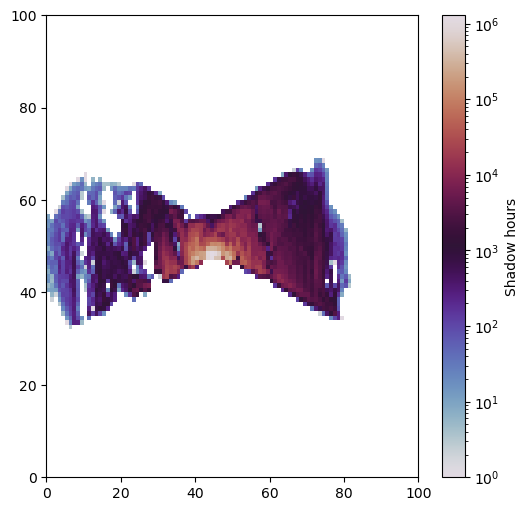

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
ct = ax.pcolormesh(shadow_map, cmap = "twilight", norm=LogNorm())
plt.colorbar(ct, ax = ax, label='Shadow hours')
plt.show()